# Policy
* 이 노트북 파일은 중간 과제를 재현Reproduce하는 증거로 활용.
    * 따라서, 이 노트북에 기재된 코드를 실행했을 때, Kaggle에 제출한 결과와 일치해야함
    * 무작위성 등으로 인하여 결과가 매번 달라지는 경우에는 Random Seed 등을 설정해서 항상 같은 결과가 나오도록 할 것(예. scikit-learn의 **random_state** 등)
* 다음과 같은 정책을 어길 시 0점 처리되니 유의할 것
    * 노트북에 기재된 코드를 전체 실행했을 때 오류 등으로 실행이 되지 않는 경우
    * 노트북에 명시되지 않은 별도의 코드 및 라이브러리를 사용하는 경우
        * 과제 수행에 필요한 외부 라이브러리 설치 명령은 이 노트북 내에 명시할 것(Installing Libraries 참조)
        * 별도의 Python 파일은 사용하지 말 것. 필요하다면 이 노트북 내에서 구현.
    * 중간 과제에서 제공한 데이터 이외의 별도의 데이터를 사용하는 경우
    * 노트북 파일 내에서 훈련된 모델이 아닌 다른 모델을 사용하는 경우
    * Kaggle 제출 결과와 노트북 파일 실행으로 나온 결과가 크게 다를 경우

# Installing Libraries

아래에 중간 과제를 수행하는 데 필요한 라이브러리 들을 설치하는 명령어를 넣을 것
예를 들어,
```shell
%conda install sklearn
```
또는
```shell
%pip install -U sklearn
```
버전이 중요하다면, 버전도 명확하게 명시할 것
```shell
%conda install sklearn==1.4.2
```
또는
```shell
%pip install sklearn==1.4.2
```

In [1]:
# 설치하는 라이브러리 명시
!pip install -q scikit-learn==1.4.1.post1 numpy pandas altair kaggle==1.6.6 graphviz
!pip install -q xgboost lightgbm catboost statsmodels plotly imbalanced-learn
!pip install -q wget PyGithub openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 8.4 MB/s eta 0:00:00


In [2]:
import os
from os import path

import glob
import pandas as pd
import numpy as np
import wget
from github import Github
import shutil

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

import tensorflow as tf

# signal processing
from scipy import signal
from scipy.ndimage import label as sci_label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

# misc
import warnings

# Data Load
아래에 중간 과제에 활용할 데이터를 불러오는 부분을 넣을 것

## Kaggle에서 데이터 다운로드

In [3]:
USERNAME = "liebenholz" # username
USERKEY = "" # key

In [4]:
import json

json.dump({'username': USERNAME, 'key': USERKEY}, open('kaggle.json', mode='w'))

In [5]:
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c 2024-knu-ml-midterm
!unzip 2024-knu-ml-midterm.zip

 83% 16.0M/19.2M [00:01<00:00, 17.1MB/s]
100% 19.2M/19.2M [00:01<00:00, 12.6MB/s]
Archive:  2024-knu-ml-midterm.zip
  inflating: label.csv               
  inflating: sample_submission.csv   
  inflating: test.e4.acc-x.csv       
  inflating: test.e4.acc-y.csv       
  inflating: test.e4.acc-z.csv       
  inflating: test.e4.bvp.csv         
  inflating: test.e4.eda.csv         
  inflating: test.e4.hr.csv          
  inflating: test.e4.ibi.csv         
  inflating: test.e4.temp.csv        
  inflating: test.mindwave.alpha-high.csv  
  inflating: test.mindwave.alpha-low.csv  
  inflating: test.mindwave.beta-high.csv  
  inflating: test.mindwave.beta-low.csv  
  inflating: test.mindwave.delta.csv  
  inflating: test.mindwave.gamma-low.csv  
  inflating: test.mindwave.gamma-mid.csv  
  inflating: test.mindwave.theta.csv  
  inflating: train.e4.acc-x.csv      
  inflating: train.e4.acc-y.csv      
  inflating: train.e4.acc-z.csv      
  inflating: train.e4.bvp.csv        
  inflating: tra

### Sensor Data Files
센서 데이터 파일은 각 센서값 별로 별도의 CSV 파일로 저장되어 있으며, 다음과 같은 파일명 형식을 따른다.

- train.{센서 종류}.{센서값 종류}.csv: 훈련 데이터
- test.{센서 종류}.{센서값 종류}.csv: 테스트 데이터


센서 종류는 다음과 같다.

- e4: Empatica E4 웨어러블 센서
- mindwave: NeuroSky Mindwave 뇌전도(EEG) 측정 헤드셋


센서값 종류는 다음과 같다.
- acc-x: 가속도계 X축 값; 단위는 1/64 * G = 1/64 * 9.80665 m/s^2
- acc-y: 가속도계 Y축 값; 단위는 1/64 * G = 1/64 * 9.80665 m/s^2
- acc-z: 가속도계 Z축 값; 단위는 1/64 * G = 1/64 * 9.80665 m/s^2
- bvp: 광혈류측정계(Photoplethysmography; PPG)를 통해 수집된 혈류파(Blood Volume Pulse); 단위는 nano watt
- eda: 피부전도도(Electrodermal Activity); 단위는 micro siemens
- hr: 심박수(Heart rate); 단위는 beat per minute
- ibi: 심박 간격(Inter-beat Interval); 단위는 milliseconds
- temp: 피부 온도; 단위는 섭씨(Celsius degree)
- delta: 뇌파 - 델타파(delta wave; 0.5 - 2.75Hz 대역)의 상대적 강도
- theta: 뇌파 - 세타파(theta wave; 3.5 - 6.75Hz 대역)의 상대적 강도
- alpha-low: 뇌파 - 저대역 알파파(low-alpha wave; 7.5 - 9.25Hz 대역)의 상대적 강도
- alpha-high: 뇌파- 고대역 알파파(high-alpha wave; 10 - 11.75Hz 대역)의 상대적 강도
- beta-low: 뇌파 - 저대역 베타파(low-beta wave; 13 - 16.75Hz 대역)의 상대적 강도
- beta-high: 뇌파 - 고대역 베타파(high-beta wave; 18 - 29.75Hz 대역)의 상대적 강도
- gamma-low: 뇌파 - 저대역 베타파(low-gamma wave; 31 - 39.75Hz 대역)의 상대적 강도
- gamma-mid: 뇌파 - 중대역 감마파(mid-gamma wave; 41 - 49.75Hz 대역)의 상대적 강도

※ 뇌파의 상대적 강도는 별도의 단위가 없으며, 다른 대역과 비교했을때의 상대적 신호 강도를 의미한다. 정규화 또는 일반화 된 값이라고 여기면 된다.


각 센서 데이터 파일은 3개의 필드로 구성되어 있다

- timestamp: 해당 센서값이 수집된 millisecond 단위의 시점; 서로 다른 피험자의 센서 데이터가 서로 겹치지 않도록 시간을 조정하였다.
- value: 수집된 센서 값
- pid: 피험자 ID로, A부터 Y까지 총 25명이다. 이 중 12명은 훈련 데이터, 13명은 테스트 데이터로 활용된다.

### Label Files
훈련 데이터에 대한 레이블 정보는 label.csv에 기록되어 있으며, 다음과 같이 2개의 필드로 구성되어 있다.

- id: 감정 레이블이 부여된 millisecond 단위의 시점
서로 다른 피험자의 레이블이 서로 겹치지 않도록 값을 조정하였다.
- label: 레이블 값으로 0, 1, 2, 3의 값이 존재한다.
  - 0 - 조용하고 부정적인 감정(예. 우울함, 피곤함, 지루함 등)
  - 1 - 조용하고 긍정적인 감정(예. 침착함, 편안함 등)
  - 2 - 활달하고 부정적인 감정(예. 화남, 긴장함 등)
  - 3 - 활달하고 긍정적인 감정(예. 행복함, 신남 등)
### Submission
테스트 데이터에 대한 예측 id 및 제출 예시는 sample_submission.csv에 기록되어 있으며, label.csv와 동일한 필드 및 의미를 가진다.

## 다운로드한 데이터 불러오기

In [11]:
# pd.read_csv(...)
LABEL = pd.read_csv('./label.csv', index_col='id')
TRAIN_E4X = pd.read_csv('./train.e4.acc-x.csv')
TRAIN_E4Y = pd.read_csv('./train.e4.acc-y.csv')
TRAIN_E4Z = pd.read_csv('./train.e4.acc-z.csv')
TRAIN_BVP = pd.read_csv('./train.e4.bvp.csv')
TRAIN_EDA = pd.read_csv('./train.e4.eda.csv')
TRAIN_HR = pd.read_csv('./train.e4.hr.csv')
TRAIN_IBI = pd.read_csv('./train.e4.ibi.csv')
TRAIN_ALPHA_H = pd.read_csv('./train.mindwave.alpha-high.csv')
TRAIN_ALPHA_L = pd.read_csv('./train.mindwave.alpha-low.csv')
TRAIN_BETA_H = pd.read_csv('./train.mindwave.beta-high.csv')
TRAIN_BETA_L = pd.read_csv('./train.mindwave.beta-low.csv')
TRAIN_DELTA = pd.read_csv('./train.mindwave.delta.csv')
TRAIN_GAMMA_L = pd.read_csv('./train.mindwave.gamma-low.csv')
TRAIN_GAMMA_M = pd.read_csv('./train.mindwave.gamma-mid.csv')
TRAIN_THETA = pd.read_csv('./train.mindwave.theta.csv')

In [15]:
print(LABEL.shape)
LABEL.head()

(1440, 1)


,label
id,
2860000,1
2865000,1
2870000,1
2875000,1
2880000,1


array([[<Axes: title={'center': 'label'}>]], dtype=object)

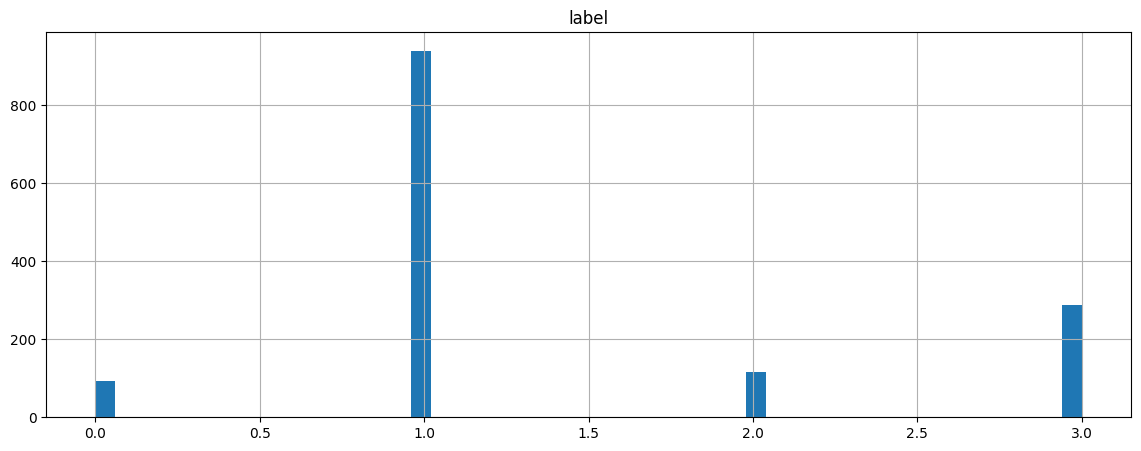

In [16]:
LABEL.hist(bins = 50, figsize = (14, 5))

# Data Preprocessing, Feature Engineering, and Model Building

이곳부터는 데이터 전처리, 특성값 공학, 모델 훈련 등의 코드를 자유롭게 넣을 것

## Dataset Description


test.e4 계열의 데이터를 타임라인에 따라 통합 test.e4.csv로 통합한다.

In [ ]:
# Write your code freely

# Final Model Specification
아래에는 위 전 과정을 거쳐서 최종적으로 선정된 모델을 정의하고 훈련할 것

In [ ]:
# from sklearn.ensemble import RandomForestClassifier


# model = RandomForestClassifier(...)

# Generate Submission
아래에는 Kaggle에 제출한 결과를 PC에 저장하는 코드를 넣을 것.
노트북 실행 후 아래의 코드를 통해 생성된 결과가 Kaggle에 제출된 결과와 일치해야 함.

In [ ]:
sample = pd.read_csv('./sample_submission.csv', index_col='id')

1번 레이블의 비중이 56% 정도 되므로 우선 이 값으로 초기화해서 제출하도록 하자.

In [ ]:
SUBMIT = pd.DataFrame({
    'id': sample.index,
    'label': 1
})
SUBMIT

,id,label
0,727000,1
1,732000,1
2,737000,1
3,742000,1
4,747000,1
...,...,...
1555,42261000,1
1556,42266000,1
1557,42271000,1
1558,42276000,1


In [ ]:
SUBMIT.to_csv('./submission.csv', index=False)

In [ ]:
!kaggle competitions submit --file submission.csv --message "First Submission, Testing with label 1" 2024-knu-ml-midterm

100% 16.5k/16.5k [00:00<00:00, 23.1kB/s]
Successfully submitted to Midterm Assignment